In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.ranked_quadh
dout = "ranked_quadh_nobkg"

In [5]:
signal = ObjIter([ Tree(f) for f in module.signal_list ])
bkg = ObjIter([ Tree(module.QCD_B_List), Tree(module.TTJets)])

100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


In [6]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

In [7]:
ranker = "20221025_ranger_lr0.0047_batch128_m10_relp4"
path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/weaver/models/quadh_ranker/{ranker}"

In [8]:
(signal+bkg).apply(lambda t : eightb.load_quadh(t, path), report=True)


100%|██████████| 5/5 [00:23<00:00,  4.76s/it]


[None, None, None, None, None]

100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


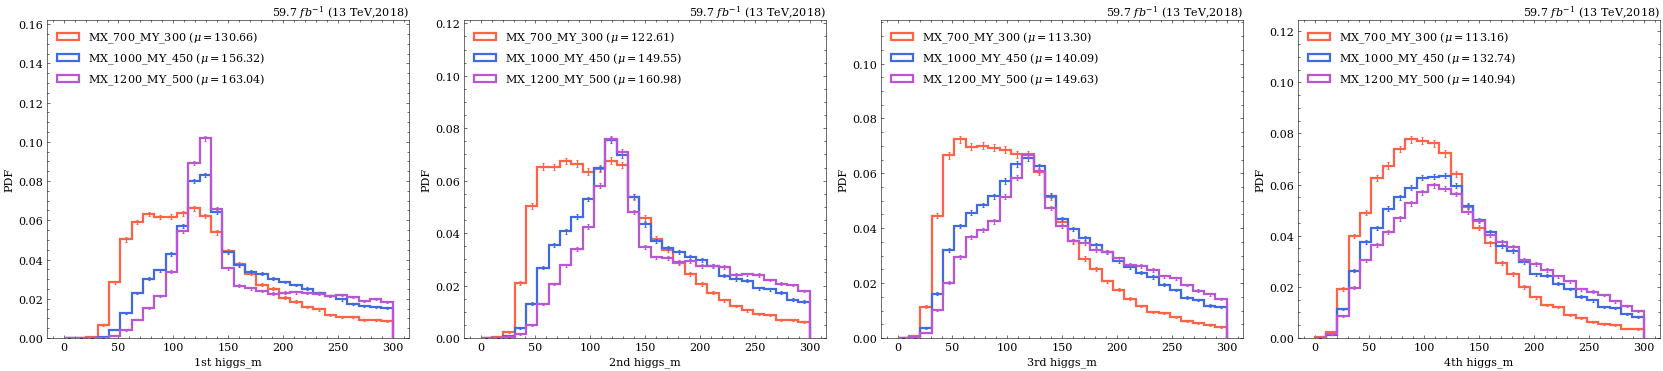

In [9]:
study.quick(
    signal,
    legend=True, h_label_stat='$\mu={stats.mean:0.2f}$',
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/higgs_m'
)

100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


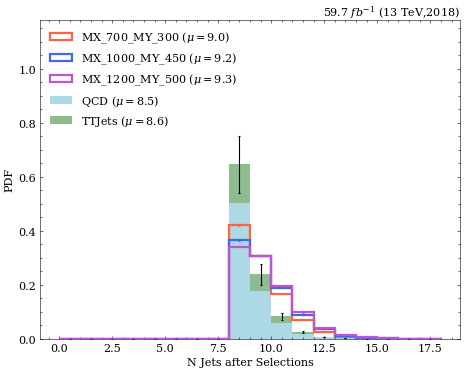

In [10]:
study.quick(
    signal+bkg, legend=True, h_label_stat='mean',
    efficiency=True,
    varlist=['n_jet'],
    xlabels=['N Jets after Selections'],
    saveas=f'{dout}/n_presel_jets'
)

100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


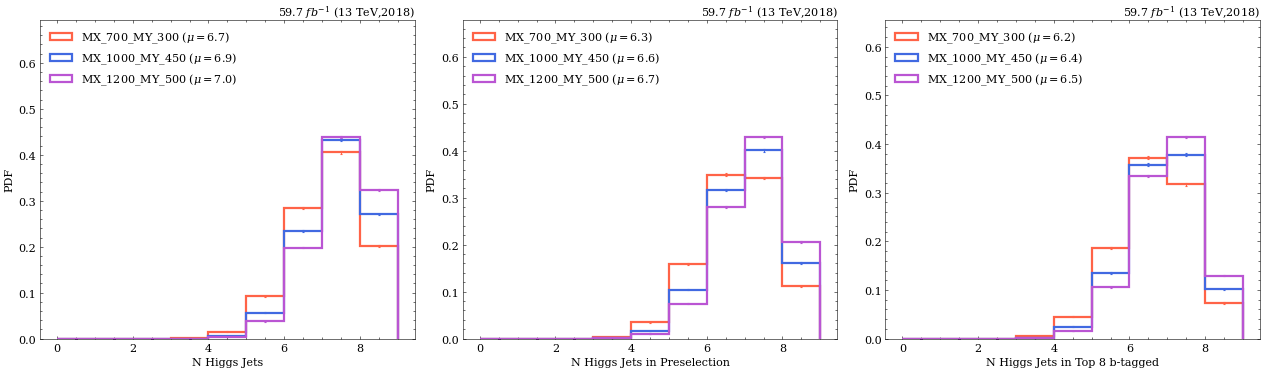

In [11]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    efficiency=True,
    varlist=['nfound_all','nfound_presel','nfound_select'],
    xlabels=['N Higgs Jets','N Higgs Jets in Preselection','N Higgs Jets in Top 8 b-tagged'],
    dim=-1,
    saveas=f'{dout}/n_higgs_jets'
)

In [12]:
njets_lost = lambda t:t.nfound_presel-t.nfound_select

def frac_events(t):
    nlost = njets_lost(t)
    return f"{ak.mean(nlost>0):0.2%}"

signal.apply(frac_events)

['14.56%', '17.56%', '19.26%']

100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


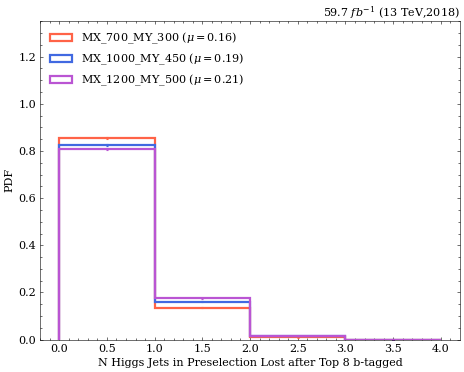

In [13]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    varlist=[njets_lost],
    xlabels=['N Higgs Jets in Preselection Lost after Top 8 b-tagged'],
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/n_higgs_jets_lost'
)

100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


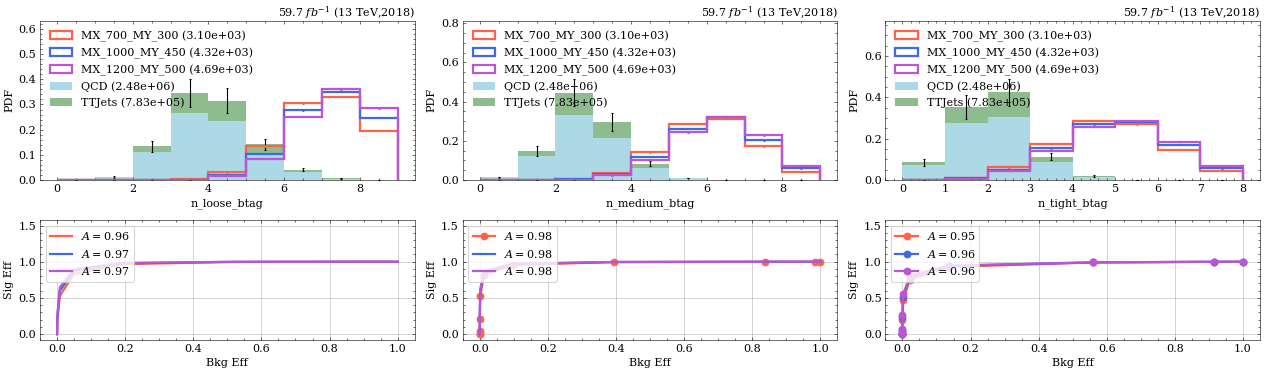

In [14]:
study.quick(
    bkg+signal, legend=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    efficiency=True, dim=-1,
    **study.auroc,

    saveas=f'{dout}/btag_multi'
)

In [15]:
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='ptRegressed'))

[None, None, None, None, None]

100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


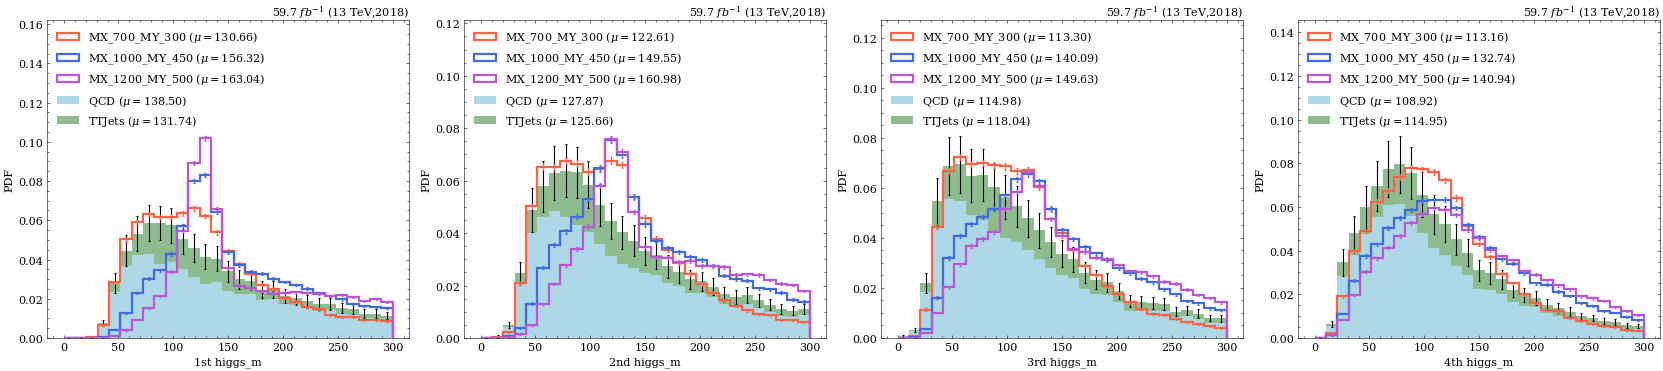

In [16]:
study.quick(
    signal+bkg,
    legend=True, h_label_stat='$\mu={stats.mean:0.2f}$',
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/higgs_m'
)

100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


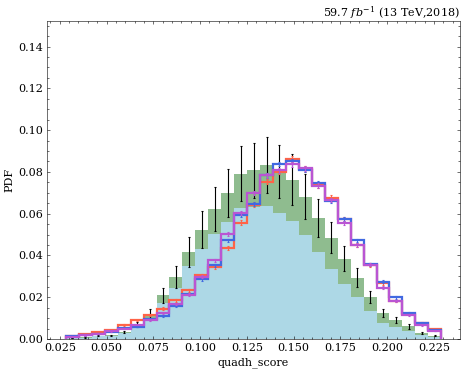

In [17]:
study.quick( 
    signal+bkg,
    efficiency=True,
    varlist=['quadh_score'],
)

100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


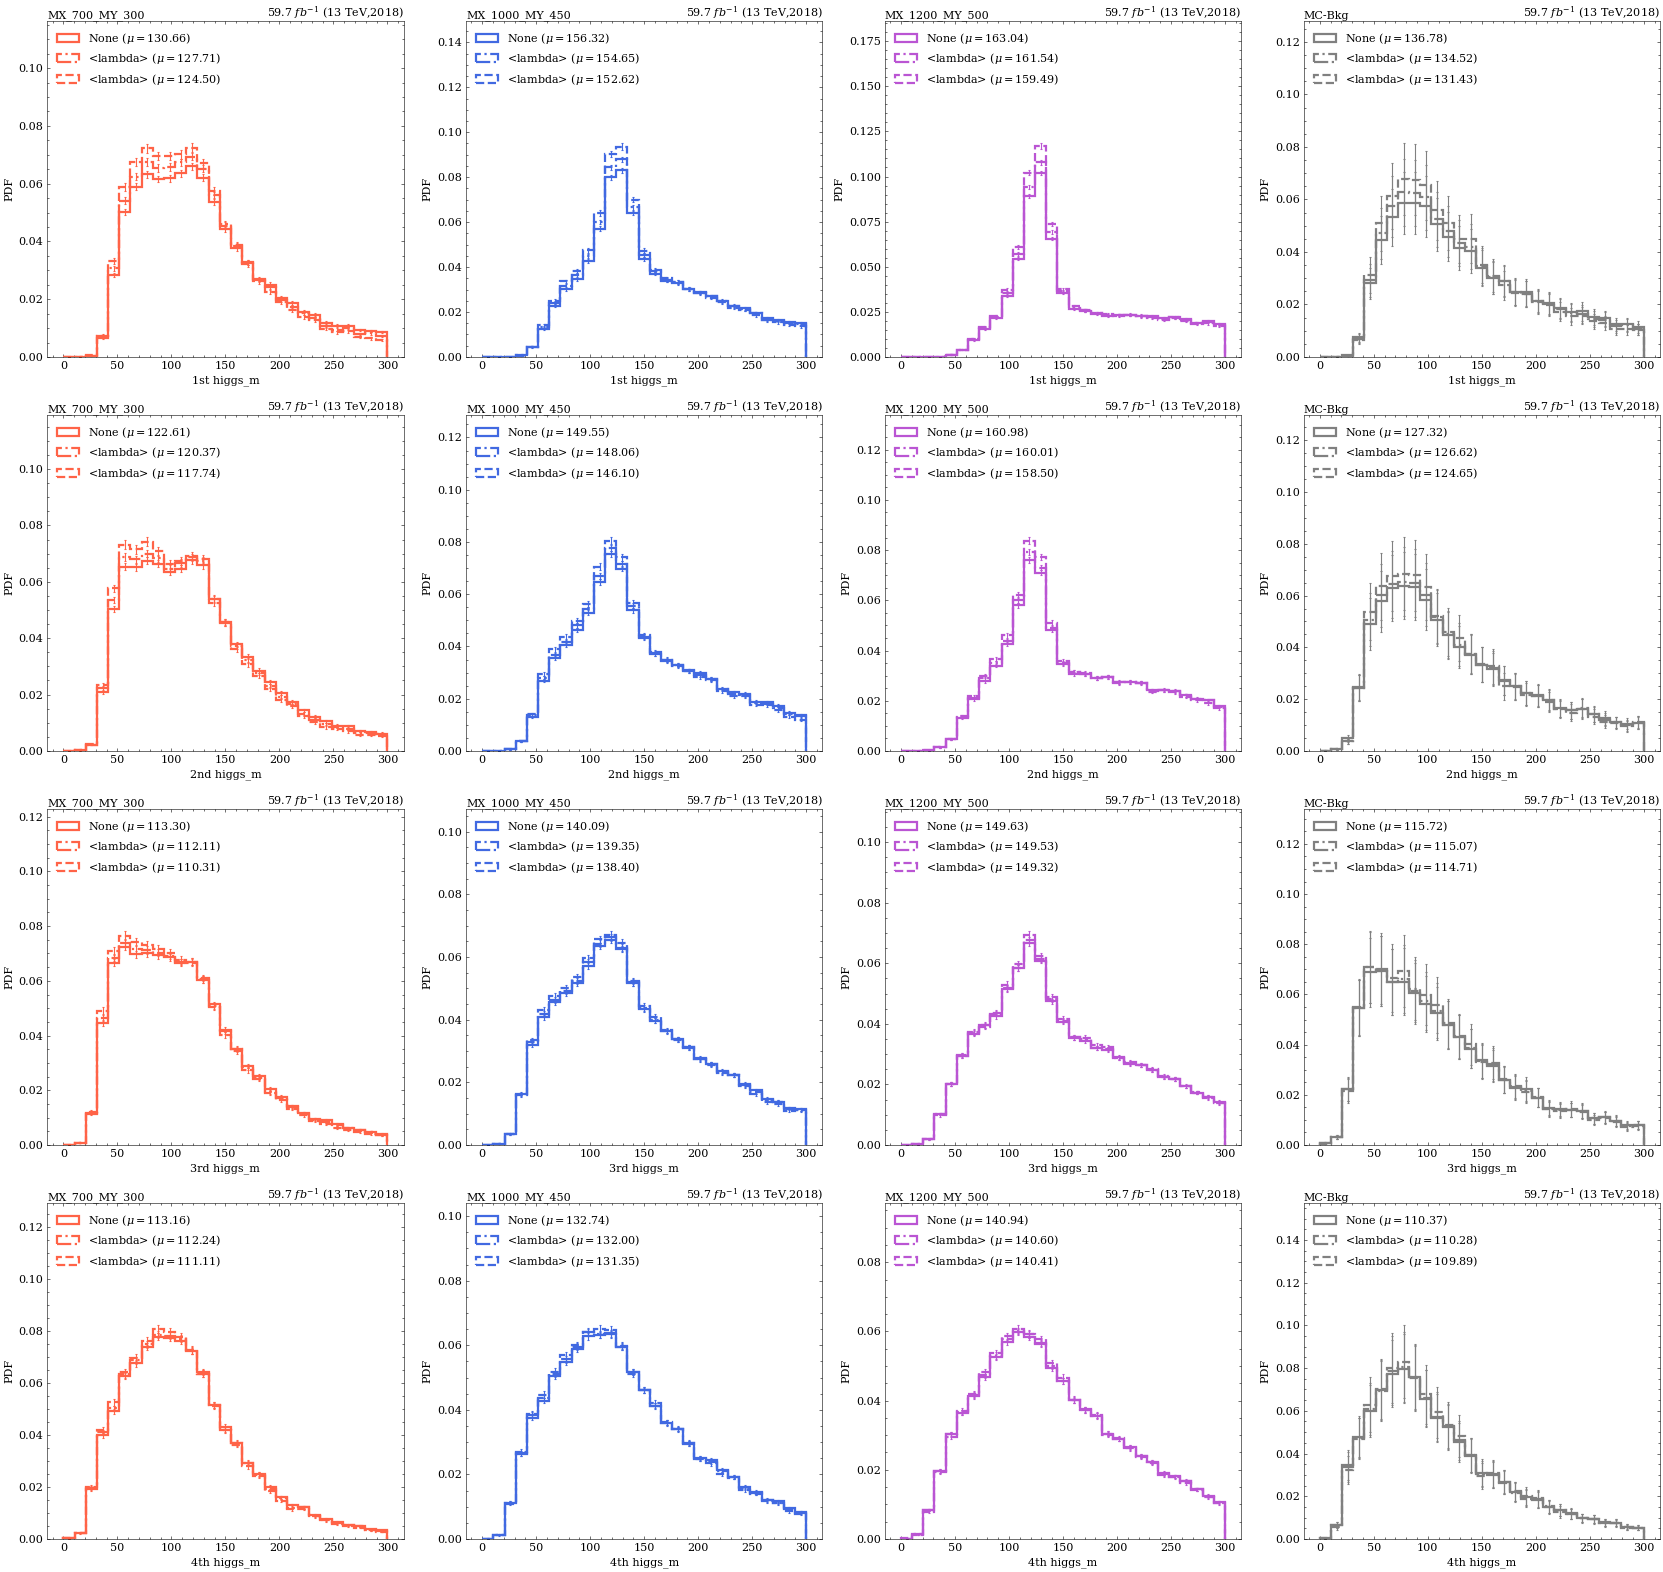

In [18]:
study.compare_masks(
    signal,bkg,
    masks=[None, lambda t:t.quadh_score>0.1, lambda t:t.quadh_score>0.125],
    legend=True, h_label_stat='$\mu={stats.mean:0.2f}$',
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
    efficiency=True,
)

100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


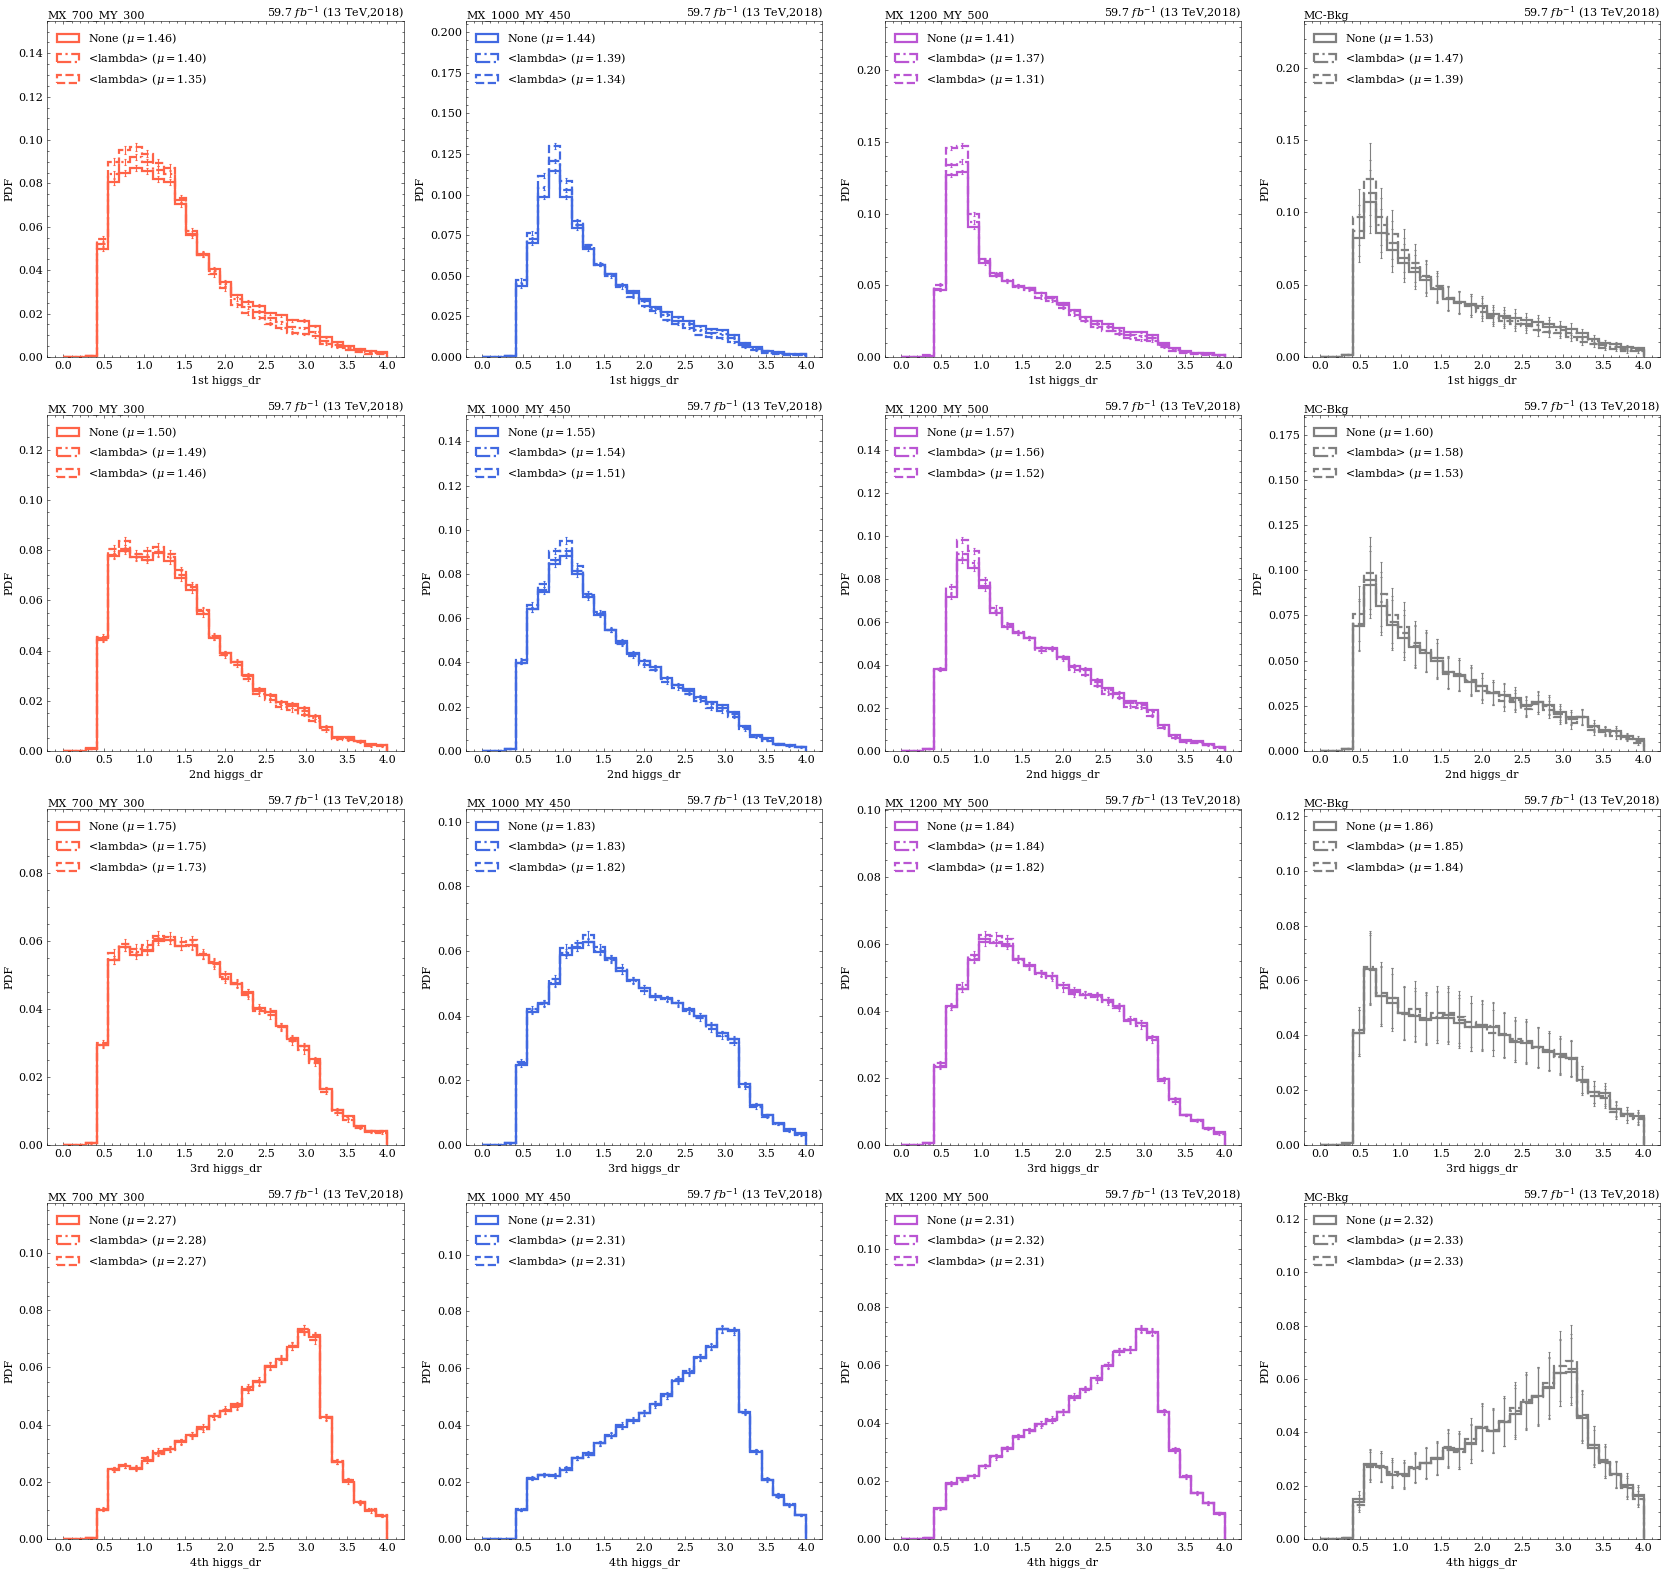

In [19]:
study.compare_masks(
    signal,bkg,
    masks=[None, lambda t:t.quadh_score>0.1, lambda t:t.quadh_score>0.125],
    legend=True, h_label_stat='$\mu={stats.mean:0.2f}$',
    varlist=[f'higgs_dr[:,{i}]' for i in range(4)],
    binlist=[(0,4,30)]*4,
    dim=-1,
    efficiency=True,
)

100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


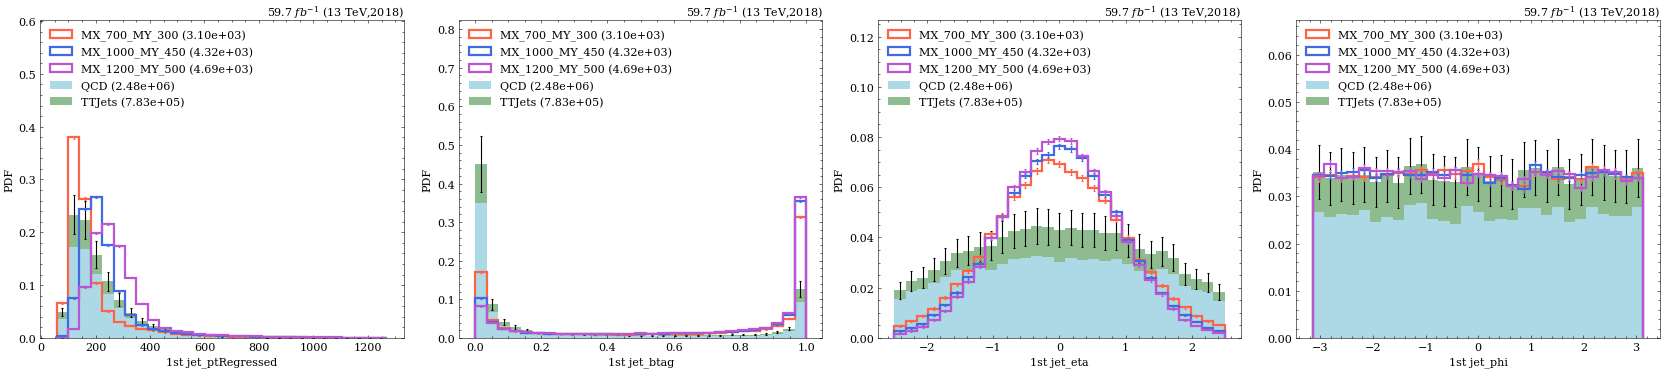

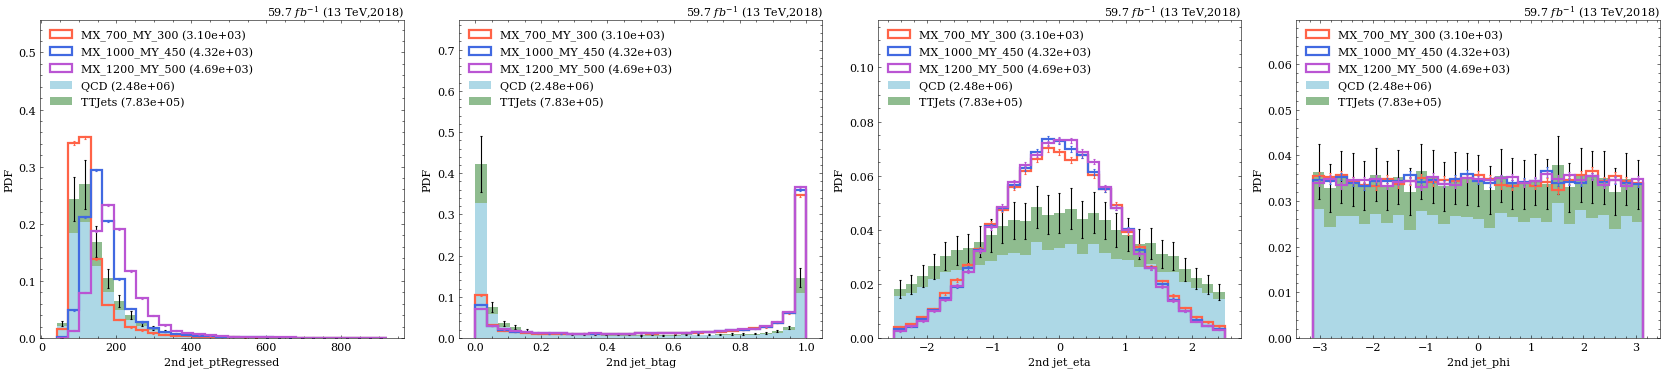

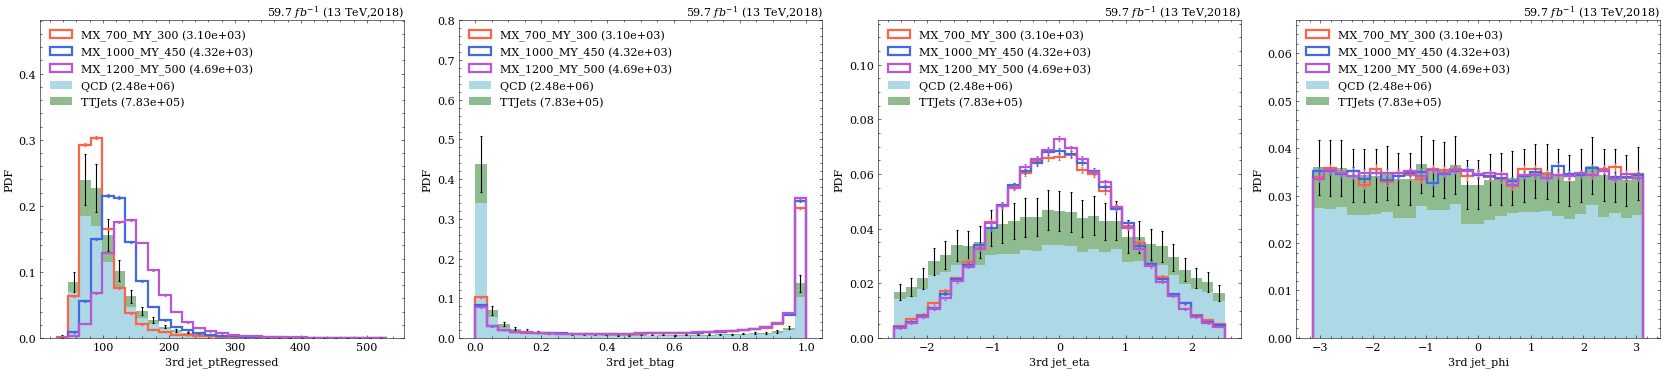

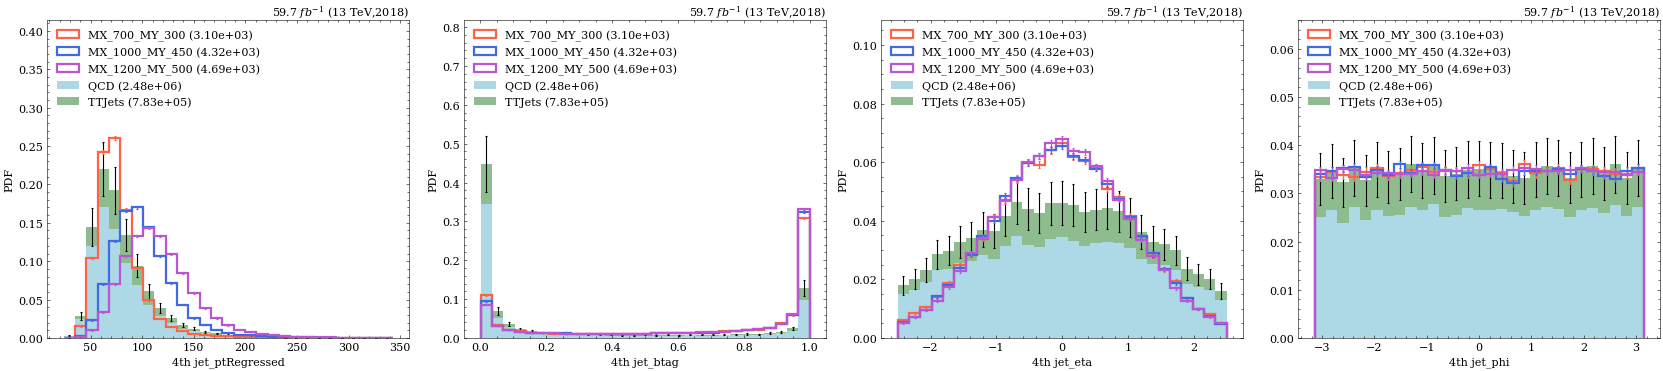

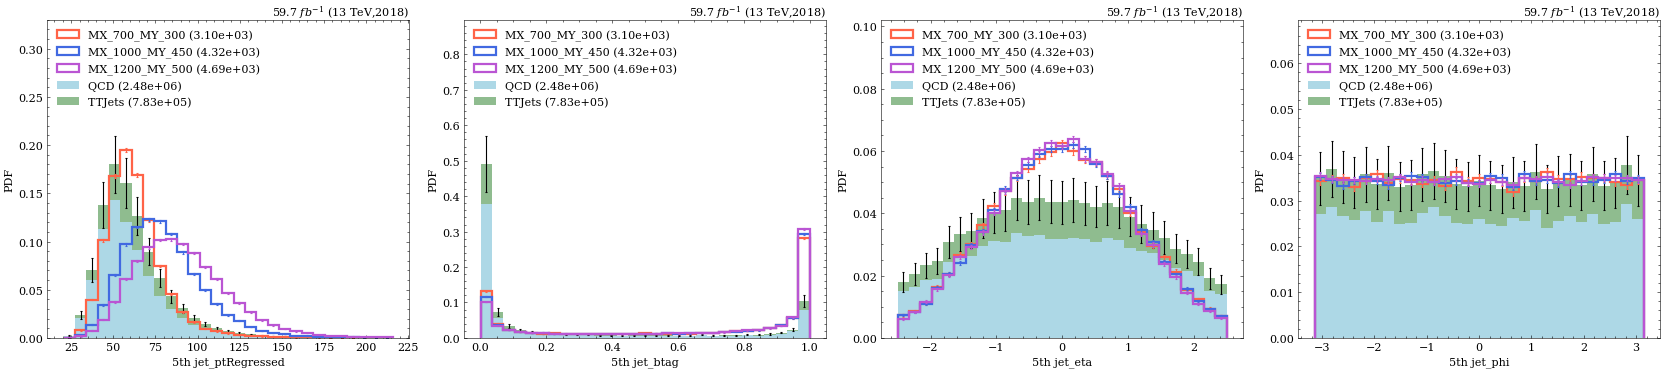

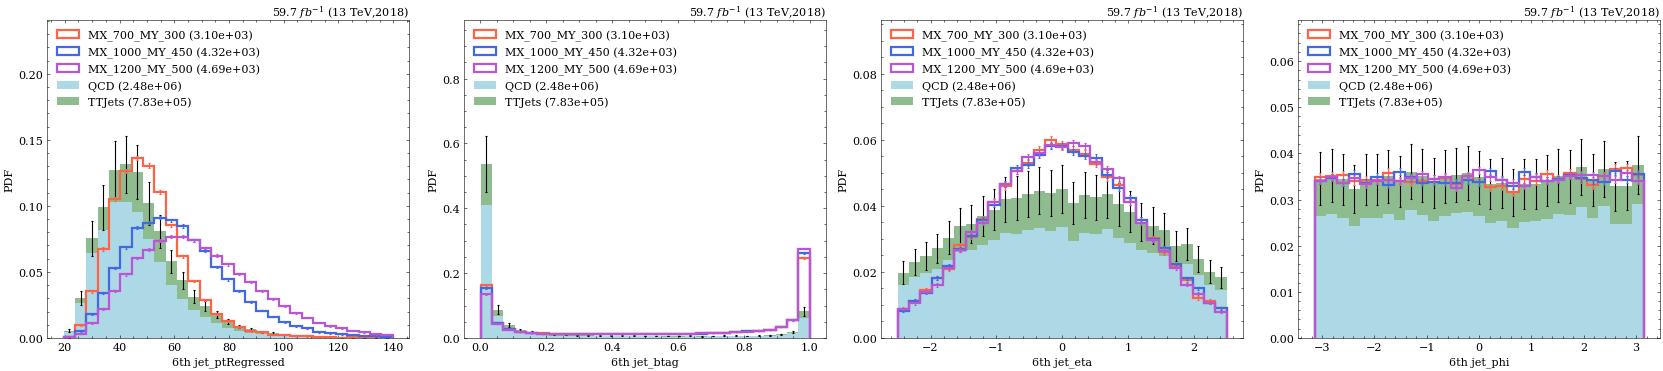

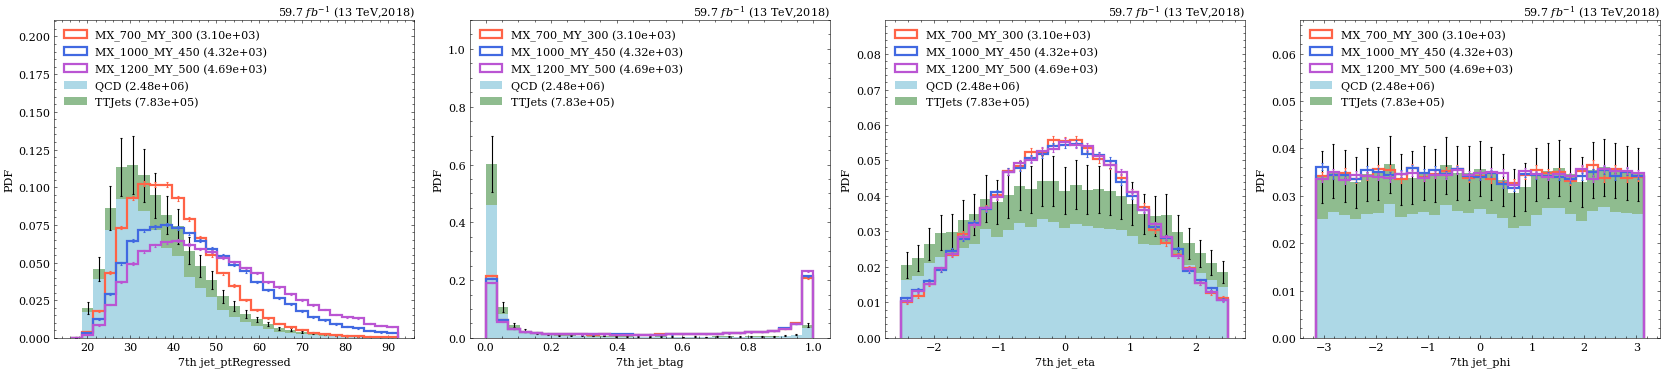

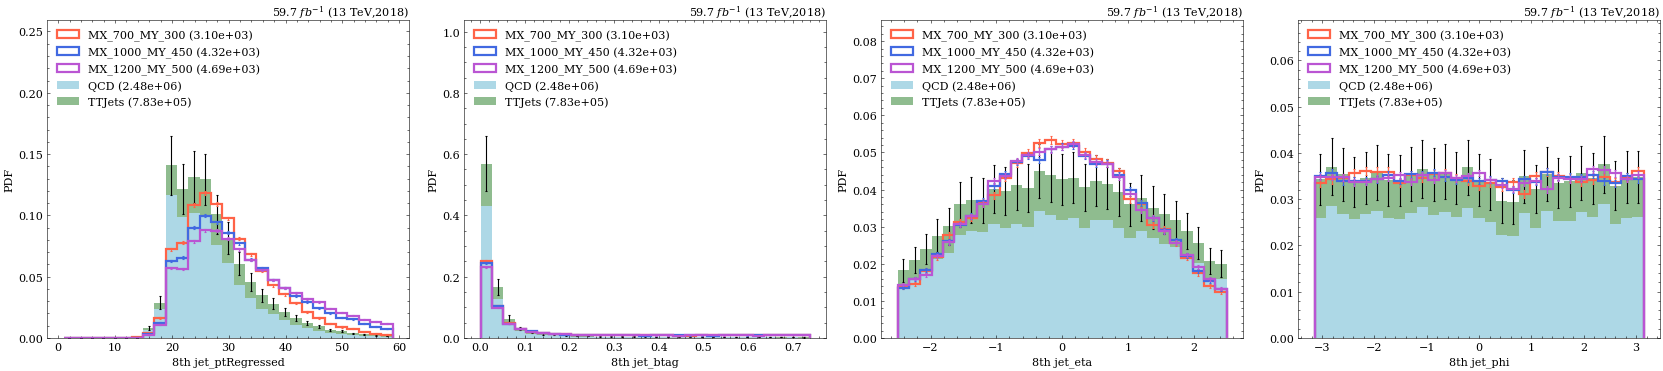

In [16]:
for i in range(8):
    study.quick( 
        signal+bkg, legend=True, 
        varlist=[f'jet_{var}[:,{i}]' for var in ('ptRegressed','btag','eta','phi')],
        efficiency=True,
        dim=-1,
        saveas=f'{dout}/{ordinal(i)}_pt_jet'
    )

In [26]:
varinfo.higgs_m = dict(bins=(0,500,30))
varinfo.higgs_dr = dict(bins=(0,4,30))

100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


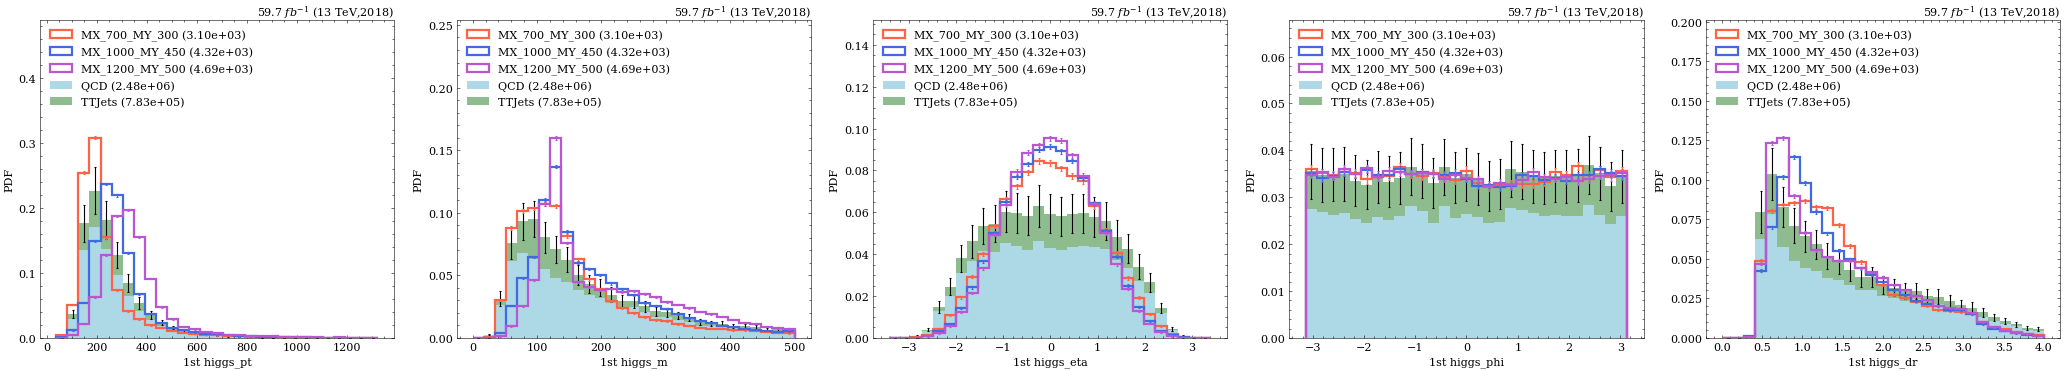

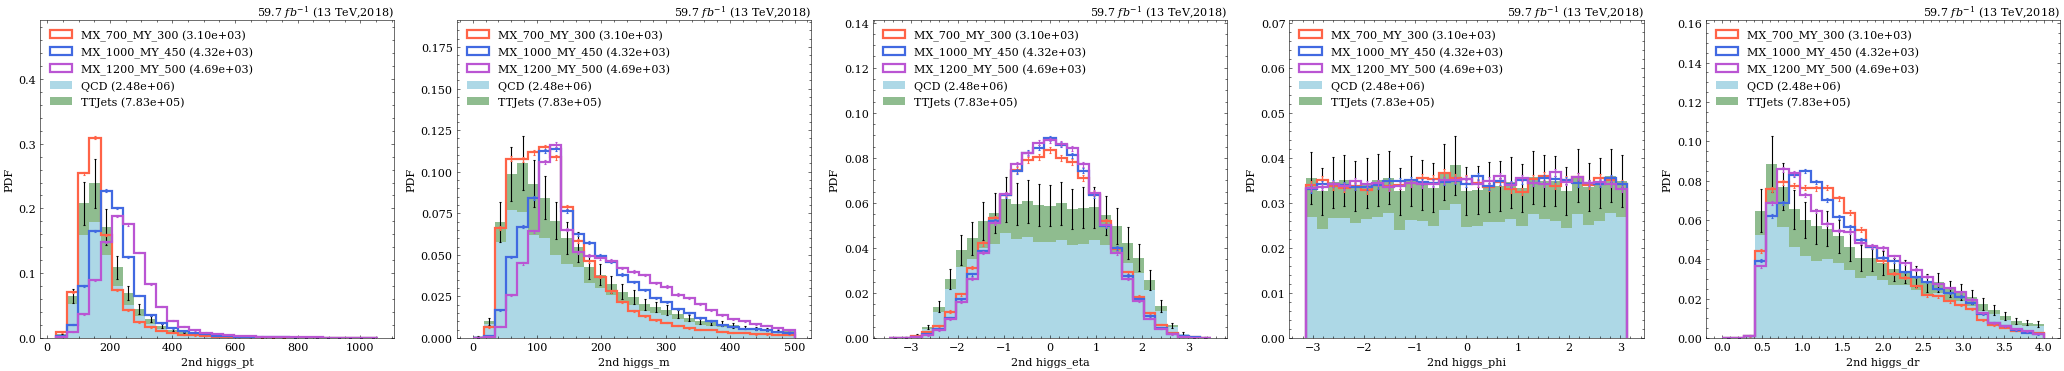

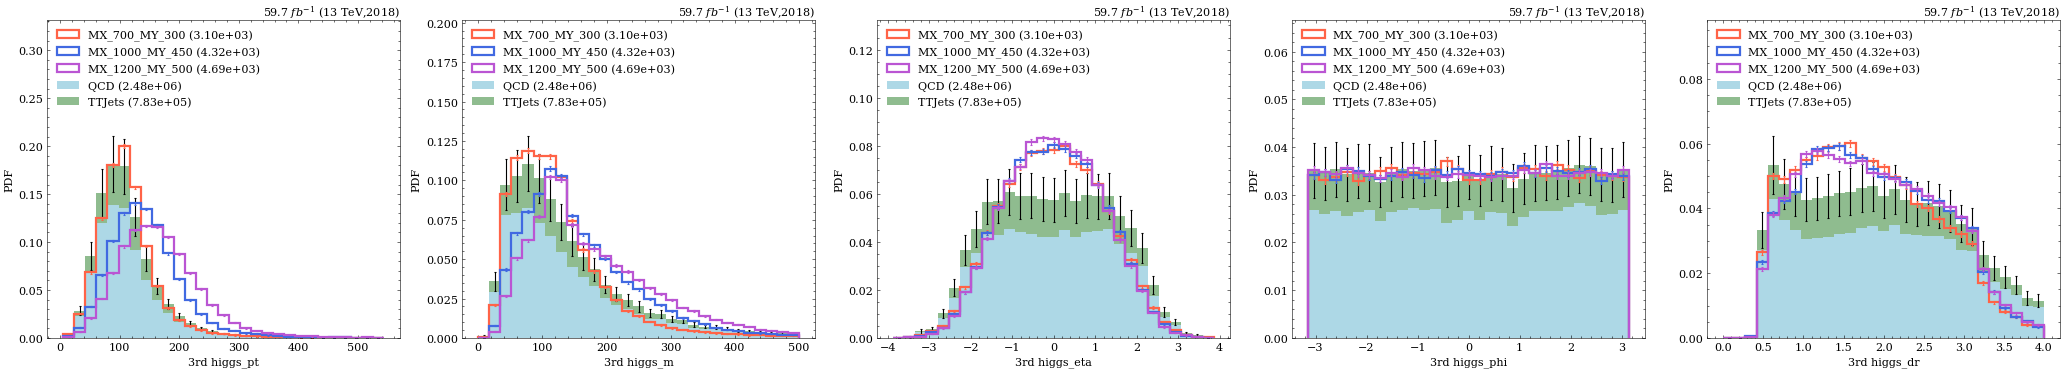

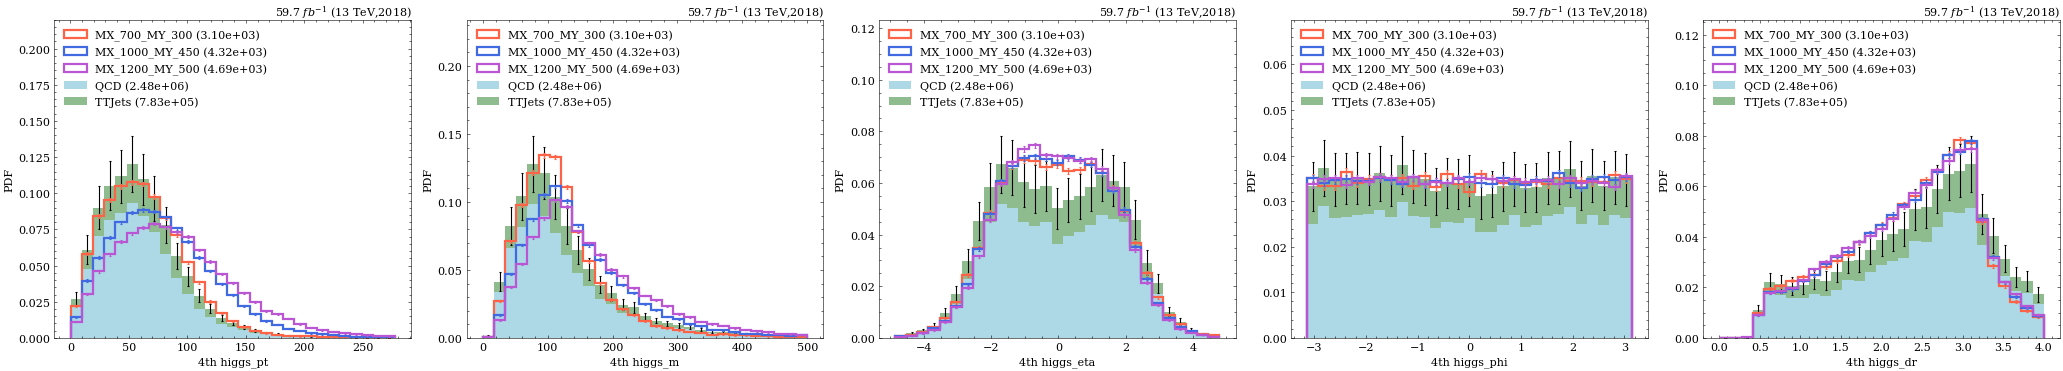

In [27]:
for i in range(4):
    study.quick( 
        signal+bkg, legend=True, efficiency=True,
        varlist=[f'higgs_{var}[:,{i}]' for var in ('pt','m','eta','phi','dr')],
        dim=-1,
        saveas=f'{ordinal(i)}_pt_higgs'
    )

In [19]:
# for i in range(2):
#     study.quick( 
#         signal+bkg, legend=True, efficiency=True,
#         varlist=[f'Y{i+1}_{var}' for var in ('pt','m','eta','phi')],
#         dim=-1,
#         saveas=f'{dout}/{ordinal(i)}_pt_y'
#     )

In [23]:
varinfo.X_m = dict(bins=(500,2000,30))

100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


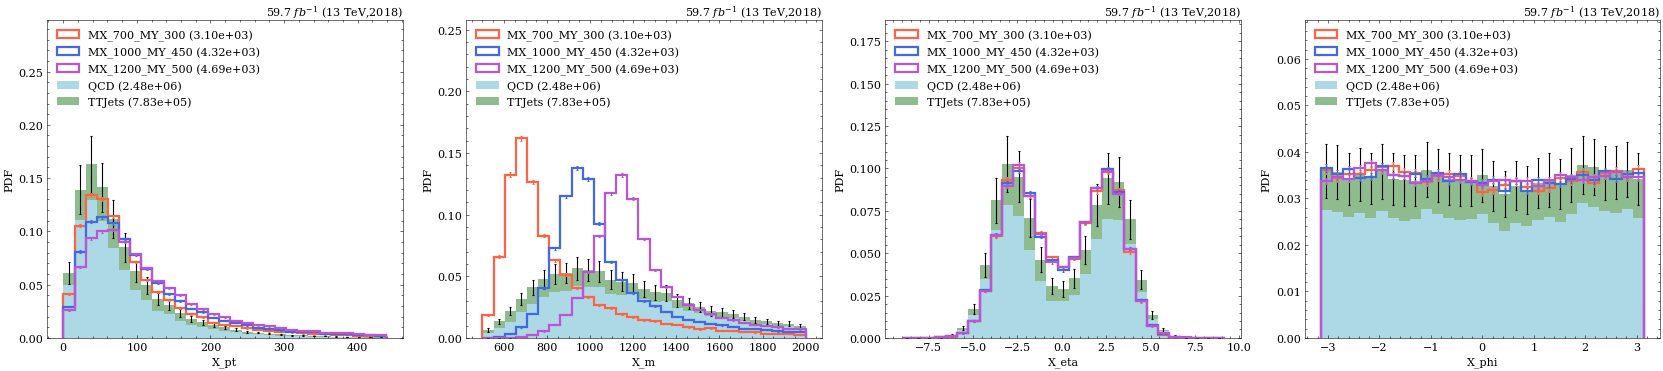

In [24]:
study.quick( 
    signal+bkg, legend=True, efficiency=True,
    varlist=[f'X_{var}' for var in ('pt','m','eta','phi')],
    dim=-1,
    saveas=f'{dout}/X'
)

100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


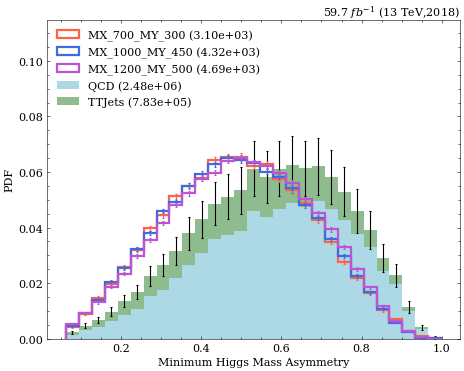

In [27]:
def hm_asym(t):
    hm = np.abs(t.higgs_m)
    hm_max, hm_min = ak.max(hm, axis=-1), ak.min(hm, axis=-1)
    asym = (hm_max-hm_min)/(hm_max+hm_min)
    t.extend(hm_asym=asym)
    return asym

study.quick(
    signal+bkg, 
    legend=True,
    # efficiency=True, 
    efficiency=True,
    varlist=[hm_asym],
    xlabels=['Minimum Higgs Mass Asymmetry'],
    saveas=f'{dout}/hm_asym',

    # **study.auroc,
)

100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


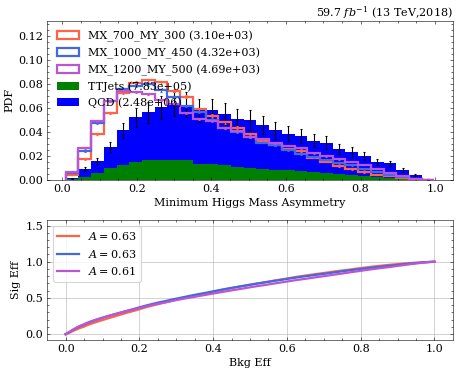

In [24]:
study.quick(
    signal+bkg, 
    legend=True,
    # log=True, 
    efficiency=True,
    varlist=[hm_asym],
    xlabels=['Minimum Higgs Mass Asymmetry'],

    **study.auroc,
    saveas=f'{dout}/hm_asym_roc',
)

100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


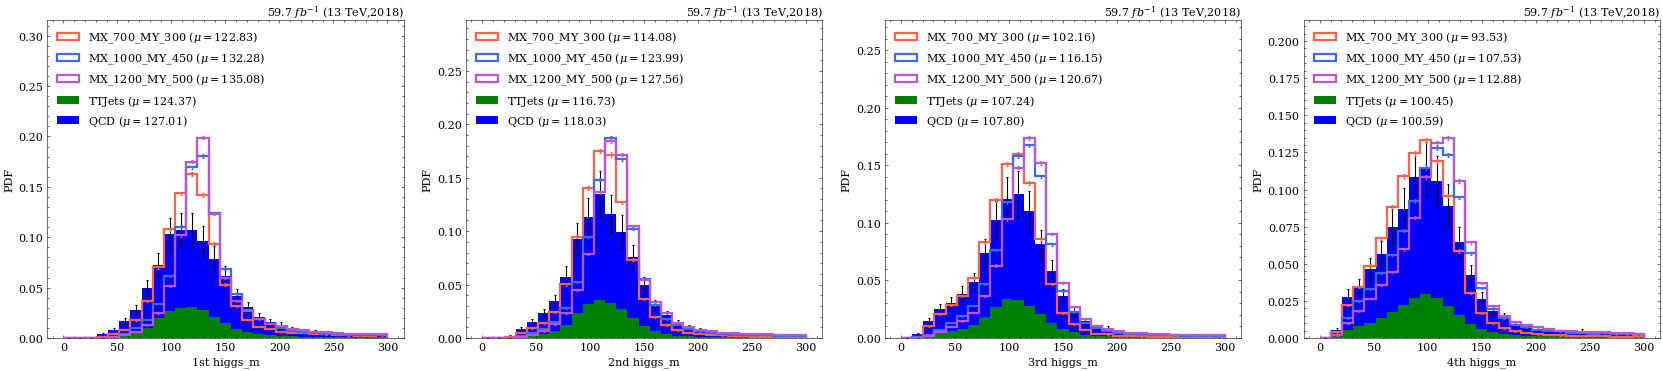

In [64]:
study.quick(
    signal+bkg,
    legend=True, h_label_stat='$\mu={stats.mean:0.2f}$',
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/higgs_m'
)

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


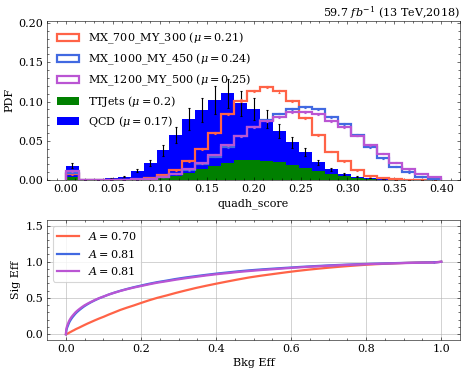

In [54]:
study.quick(
    signal+bkg, 
    legend=True,
    h_label_stat='mean',
    # log=True, 
    efficiency=True,
    varlist=['quadh_score'],
    binlist=[(0,0.4,30)],
    # xlabels=['Minimum Higgs Mass Asymmetry'],

    **study.auroc,
    saveas=f'{dout}/quadh_score_roc',
)

100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


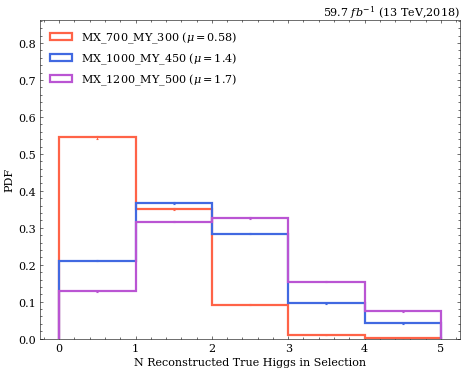

In [25]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    varlist=['nfound_paired_h'],
    efficiency=True,
    xlabels=['N Reconstructed True Higgs in Selection'],
    saveas=f'{dout}/n_higgs_reco',
)

100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


90.29%
68.87%
58.37%


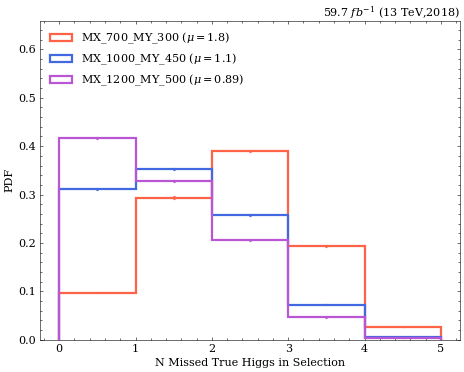

In [26]:
def frac_events(histos, **kwargs):
    for histo in histos:
        print(f"{histo.histo[1:].sum():0.2%}")

study.quick(
    signal, legend=True, h_label_stat='mean',
    varlist=[lambda t:t.nfound_select_h - t.nfound_paired_h],
    efficiency=True,
    xlabels=['N Missed True Higgs in Selection'],
    exe=frac_events,
    saveas=f'{dout}/n_higgs_missed_reco',
)

100%|██████████| 1/1 [00:03<00:00,  3.29s/it]


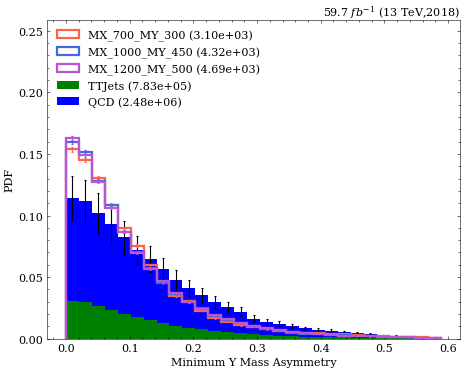

In [27]:
def ym_asym(t):
    ym = ak_stack([t.Y1_m, t.Y2_m])
    ym_max, ym_min = ak.max(ym, axis=-1), ak.min(ym, axis=-1)
    asym = (ym_max-ym_min)/(ym_max+ym_min)
    t.extend(ym_asym=asym)
    return asym

study.quick(
    signal+bkg, 
    legend=True,
    # log=True, 
    efficiency=True,
    varlist=[ym_asym],
    xlabels=['Minimum Y Mass Asymmetry'],
    saveas=f'{dout}/ym_asym',
)

100%|██████████| 1/1 [00:15<00:00, 15.98s/it]


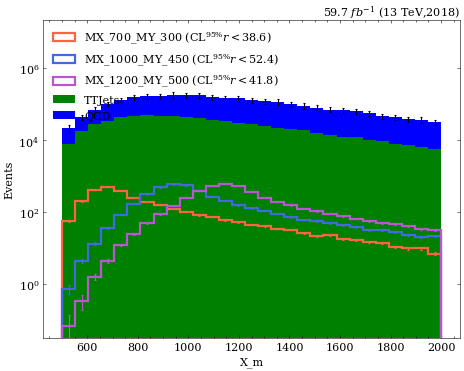

In [28]:
study.quick(
    signal+bkg, legend=True,
    log=True,
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/no_cuts'
)

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


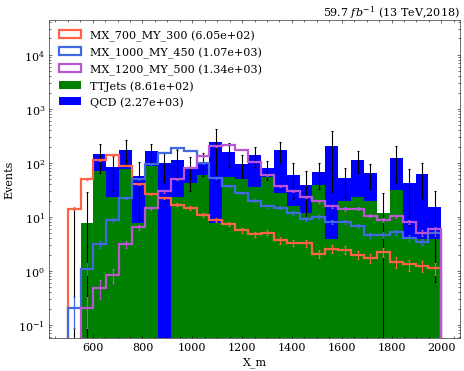

In [29]:
study.quick(
    signal+bkg, legend=True,
    masks=lambda t:t.n_loose_btag==8,
    log=True,
    varlist=['X_m'],
    saveas=f'{dout}/limits/n_loose_btag==8'
)

100%|██████████| 1/1 [00:06<00:00,  6.70s/it]


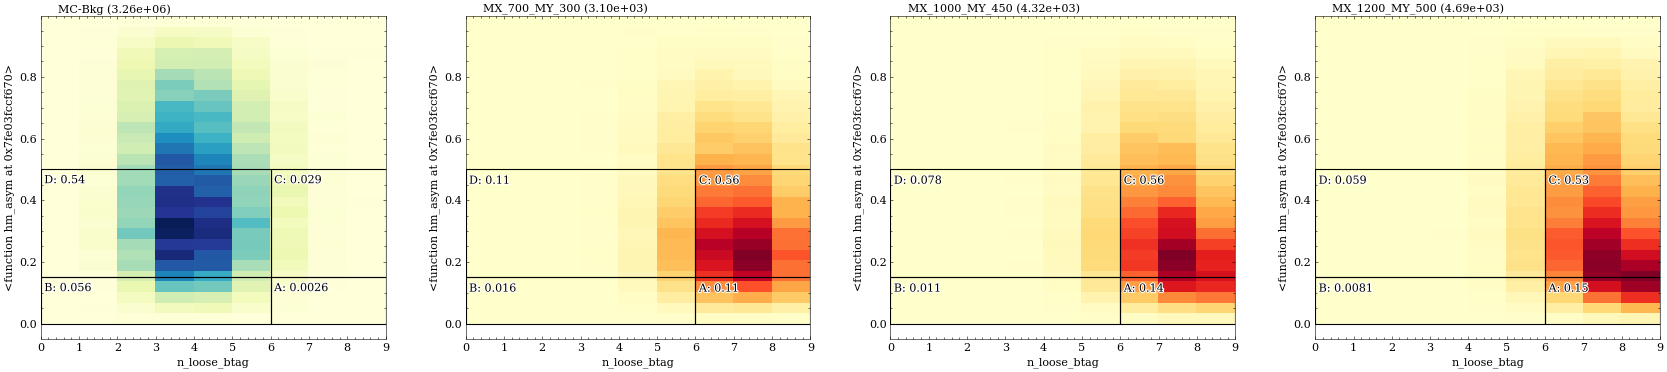

In [30]:
study.quick2d(
    signal+bkg,
    varlist=['n_loose_btag',hm_asym],
    exe=draw_abcd(x_r=(0,6,9),y_r=(0,0.15,0.5), regions=["C","D","A","B"])
)

100%|██████████| 1/1 [00:11<00:00, 11.35s/it]


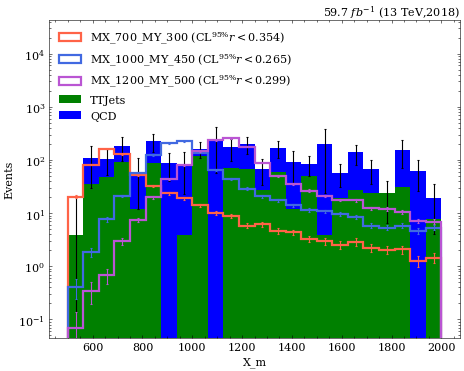

In [31]:
study.quick(
    signal+bkg, legend=True,
    masks=lambda t:t.n_loose_btag==8,
    log=True,
    varlist=['X_m'],
    binlist=[(500,2000,25)],
    limits=True,
    saveas=f'{dout}/limits/n_loose_btag==8'
)

100%|██████████| 1/1 [00:13<00:00, 13.59s/it]


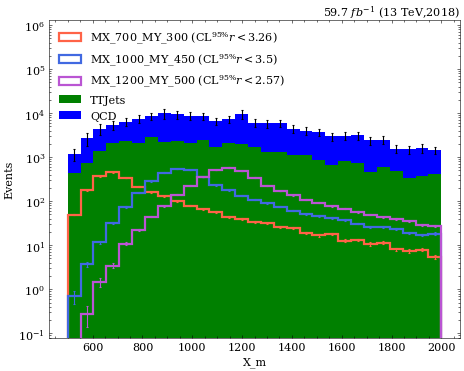

In [32]:
study.quick(
    signal+bkg, legend=True,
    masks=lambda t:t.n_loose_btag>=6,
    log=True,
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/n_loose_btag>=6'
)

100%|██████████| 1/1 [00:12<00:00, 12.19s/it]


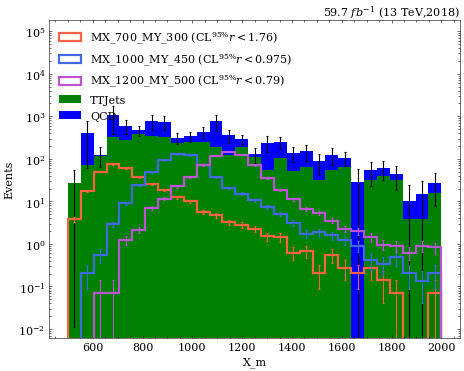

In [33]:
study.quick(
    signal+bkg, legend=True,
    masks=lambda t:(t.n_loose_btag>=6)&(t.hm_asym<0.15),
    log=True,
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/n_loose_btag>=6&hm_asym<0.15'
)

100%|██████████| 1/1 [00:12<00:00, 12.84s/it]


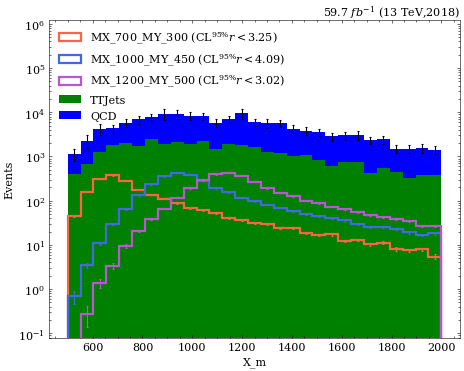

In [34]:
study.quick(
    signal+bkg, legend=True,
    masks=lambda t:(t.n_loose_btag>=6)&(t.hm_asym>=0.15),
    log=True,
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/n_loose_btag>=6&hm_asym>=0.15'
)

In [35]:
def compare_masks(var, masks, label=None, figax=None, saveas=None, **kwargs):
    n = 4
    if figax is None:
      figax = study.get_figax(n, dim=(-1,n))
    fig, axs = figax

    h_linestyle = ["-","-."]
    
    for i, sample in enumerate(signal):
      study.quick(
        [sample,sample], legend=True,
        masks=masks,
        label=label,
        h_linestyle=h_linestyle,
        varlist=[var],
        text=(0.0,1.0, sample.sample),
        text_style=dict(ha='left',va='bottom'),
        figax=(fig,axs.flat[i]),
        **kwargs,
      )

    if not bkg: return

    study.quick_region(
      bkg, bkg, legend=True, 
      masks=masks,
      h_color=['grey']*3,
      label=label,
      h_linestyle=h_linestyle,
      varlist=[var],
      text=(0.0,1.0,'MC-Bkg'),
      text_style=dict(ha='left',va='bottom'),
      figax=(fig,axs.flat[-1]),
      **kwargs,
    )

    if saveas:
      study.save_fig(fig, saveas)

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


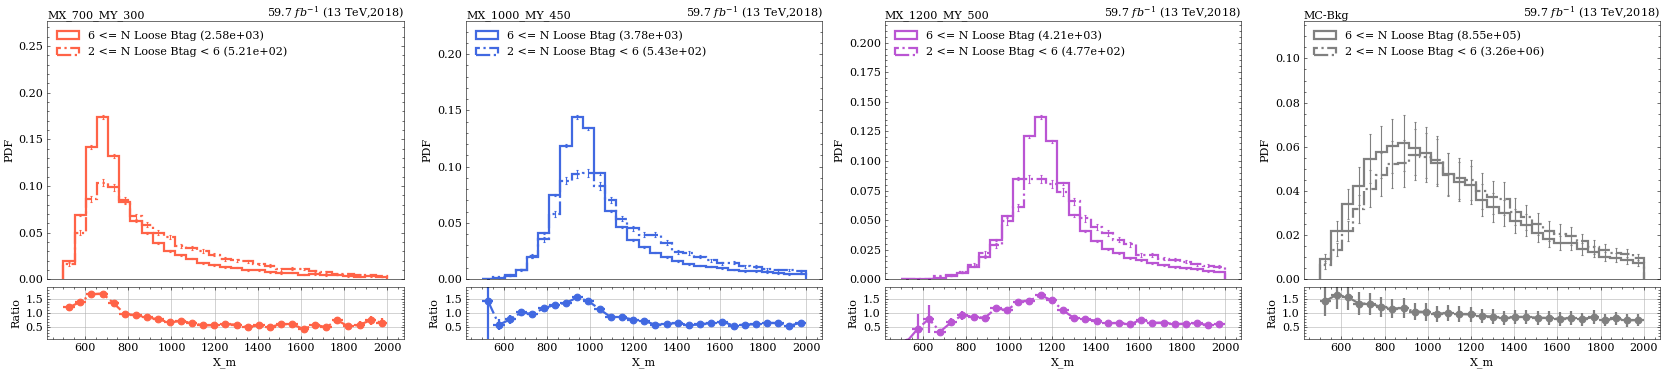

In [36]:
compare_masks(
    'X_m',
    masks=[lambda t:t.n_loose_btag>=6,lambda t:(t.n_loose_btag>=2)&(t.n_loose_btag<6)], 
    label=['6 <= N Loose Btag','2 <= N Loose Btag < 6'],
    efficiency=True,
    ratio=True,
    saveas=f'{dout}/X_m_vs_loose_btag'
    )


100%|██████████| 1/1 [00:12<00:00, 12.75s/it]


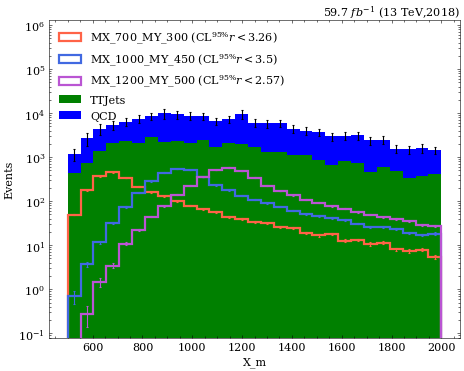

In [37]:
study.quick(
    signal+bkg, legend=True,
    masks=lambda t:(t.n_loose_btag>=6),
    log=True,
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/6<=n_loose_btag'
)

100%|██████████| 1/1 [00:14<00:00, 14.53s/it]


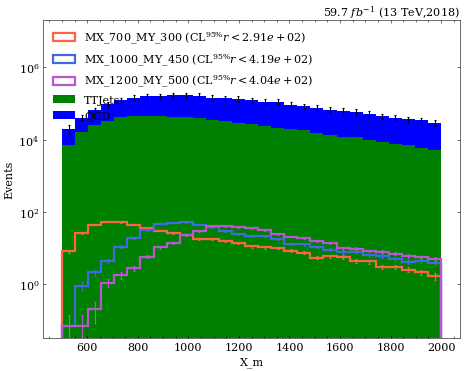

In [38]:
study.quick(
    signal+bkg, legend=True,
    masks=lambda t:(t.n_loose_btag>=2)&(t.n_loose_btag<6),
    log=True,
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/2<=n_loose_btag<6'
)

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


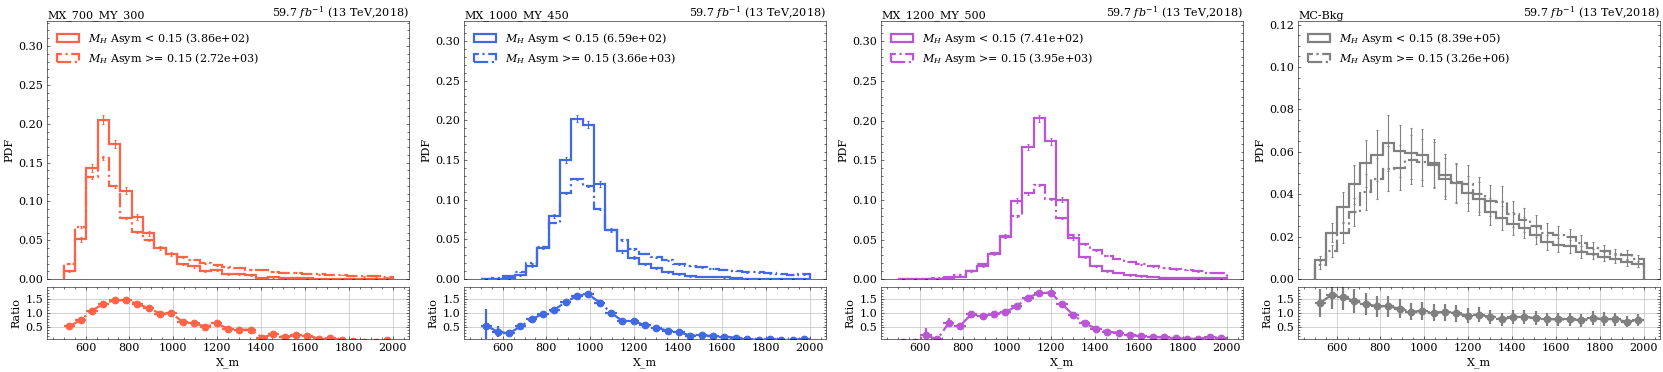

In [39]:
compare_masks(
    'X_m',
    masks=[lambda t:t.hm_asym < 0.15,lambda t:t.hm_asym >= 0.15], 
    label=['$M_{H}$ Asym < 0.15','$M_{H}$ Asym >= 0.15'],
    efficiency=True,
    ratio=True,
    saveas=f'{dout}/X_m_vs_hm_asym'
    )


100%|██████████| 1/1 [00:12<00:00, 12.86s/it]


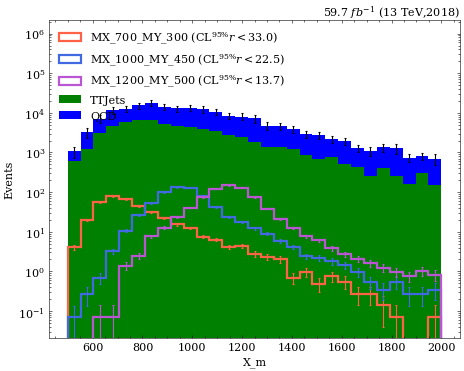

In [40]:
study.quick(
    signal+bkg, legend=True,
    masks=lambda t:t.hm_asym<0.15,
    log=True,
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/hm_asym<0.15'
)

100%|██████████| 1/1 [00:14<00:00, 14.23s/it]


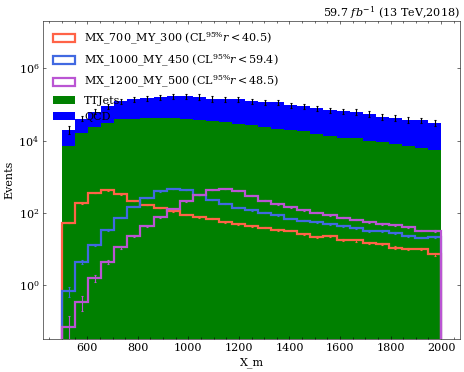

In [41]:
study.quick(
    signal+bkg, legend=True,
    masks=lambda t:t.hm_asym>=0.15,
    log=True,
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/hm_asym>=0.15'
)

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


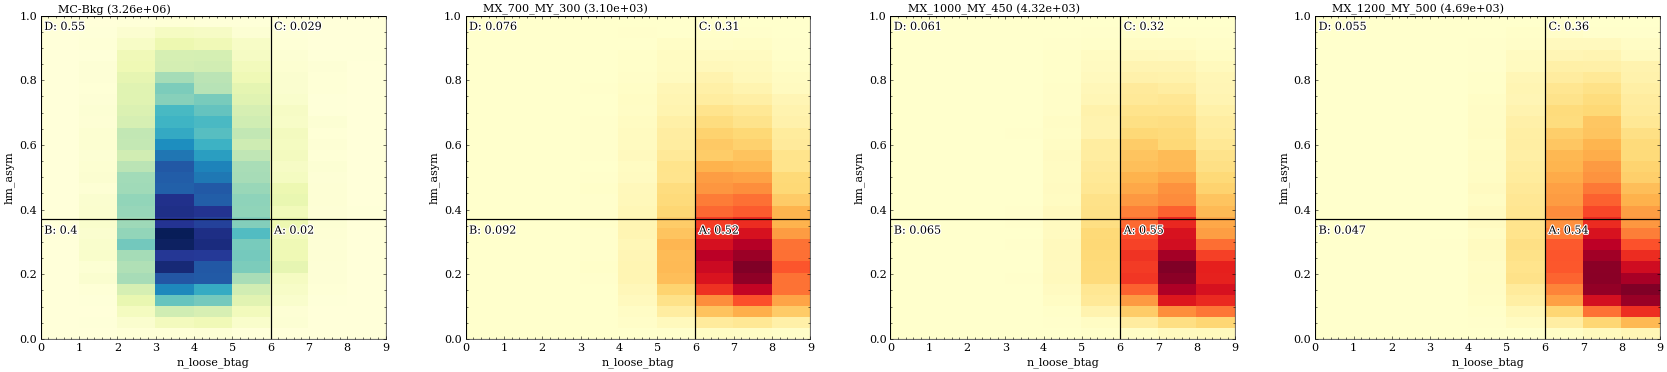

In [78]:
study.quick2d(
    signal+bkg,
    varlist=['n_loose_btag','hm_asym'],
    binlist=[None, (0,1.0,30)],
    exe=draw_abcd(x_r=(0,6,9),y_r=(0,0.37,1.0), regions=["C","D","A","B"]),
    saveas=f'{dout}/limits/abcd_loose_btag_vs_hm_asym'
)

In [79]:
bdt = ABCD(
    features=['X_m','X_pt'],
    a = lambda t : (t.n_loose_btag >= 6) &                        (t.hm_asym < 0.4),
    b = lambda t : (t.n_loose_btag >= 2) & (t.n_loose_btag < 6) & (t.hm_asym < 0.4),
    c = lambda t : (t.n_loose_btag >= 6) &                        (t.hm_asym > 0.4),
    d = lambda t : (t.n_loose_btag >= 2) & (t.n_loose_btag < 6) & (t.hm_asym > 0.4),
)

100%|██████████| 1/1 [00:13<00:00, 13.63s/it]


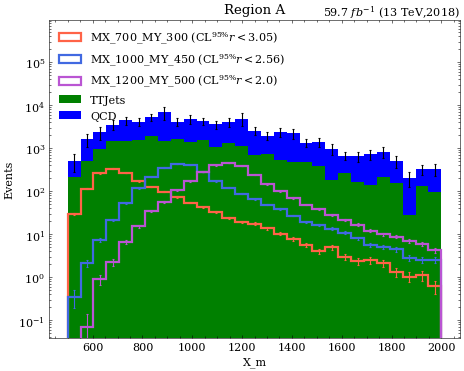

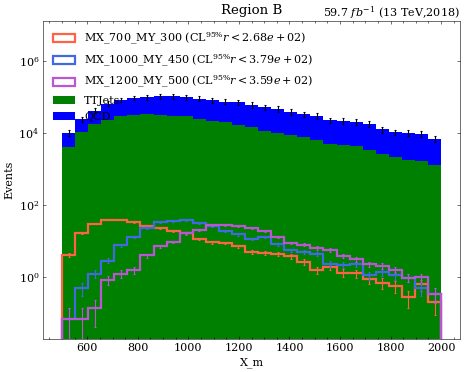

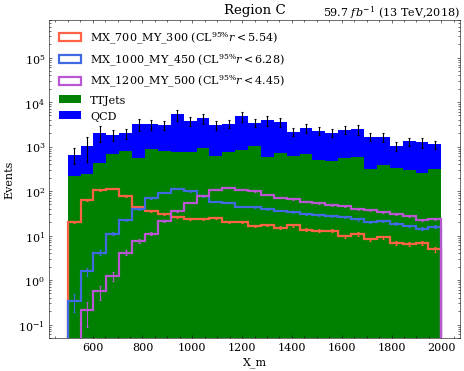

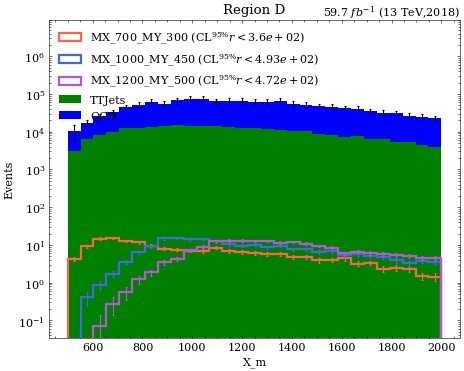

In [80]:
for r in ('a','b','c','d'):
    study.quick(
        signal + bkg, 
        legend=True,
        log=True,
        masks=getattr(bdt,r),
        varlist=['X_m'],
        limits=True,
        title=f'Region {r.upper()}',
        saveas=f'{dout}/limits/region_{r}'
    )

In [45]:
bdt.train(bkg)
bdt.print_results(bkg)

--- ABCD Results ---
k = 5.329e-02
k*(b/a)-1  = 15.42%
BDT(b)/a-1 = 11.43%



100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


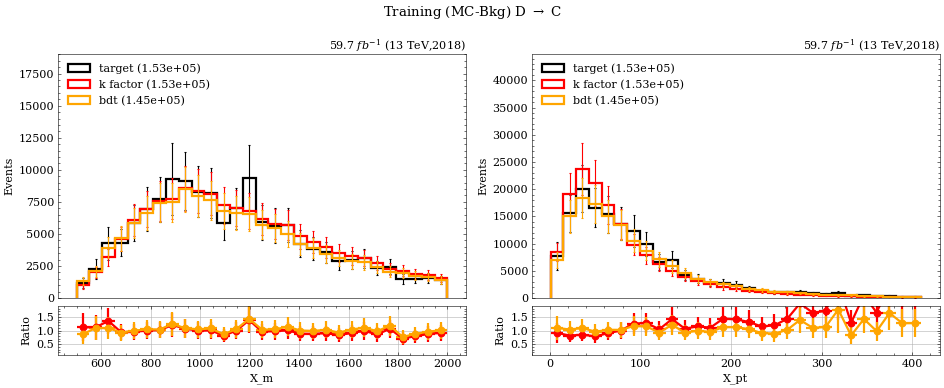

In [46]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','red','orange'], legend=True,
    masks=[bdt.c]*len(bkg)+[bdt.d]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,
    suptitle='Training (MC-Bkg) D $\\rightarrow$ C',
    ratio=True,
    saveas=f'{dout}/bdt/training'
)

100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


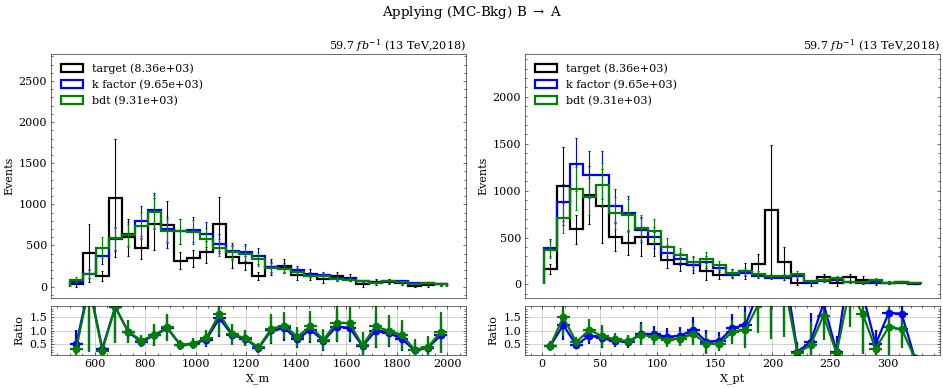

In [47]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','blue','green'], legend=True,
    masks=[bdt.a]*len(bkg)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,
    suptitle='Applying (MC-Bkg) B $\\rightarrow$ A',
    saveas=f'{dout}/bdt/applying',
    ratio=True,
)

100%|██████████| 1/1 [00:12<00:00, 12.30s/it]


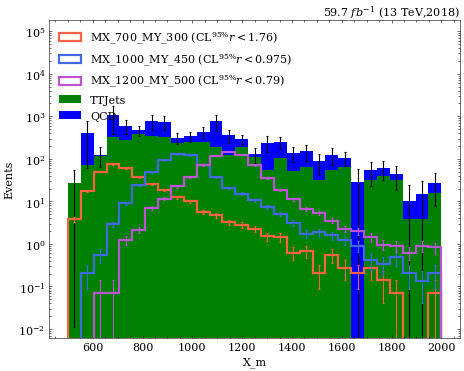

In [48]:
study.quick(
    signal + bkg, 
    legend=True,
    log=True,
    masks=bdt.a,
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/region_a'
)

100%|██████████| 1/1 [00:11<00:00, 11.80s/it]


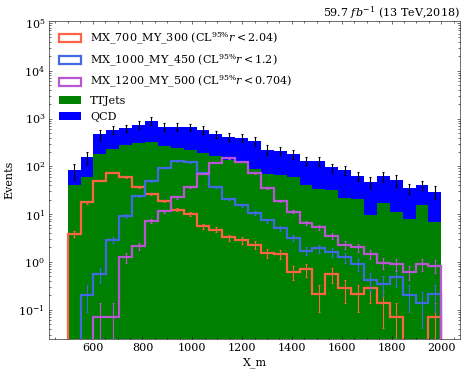

In [49]:
study.quick(
    signal + bkg, 
    legend=True,
    log=True,
    masks=[bdt.a]*len(signal)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(signal)+[bdt.reweight_tree]*len(bkg),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/bdt_bkg_model'
)